# Explore Fuse Pose Estimates
Stefan/Yuzhao Heng
Since Tues. Nov. 2nd, 2021

i.e. Get pose candidates from the HSR's laser scan in locating KUKA, and candidates from KUKA's laser scan in locating HSR.


## Setup



In [1]:
from icecream import ic

from scripts.util import *
from scripts.robo_pose_estimator import *


# hsr_scans = json_load('../data/HSR laser 2.json')
# s = hsr_scans[77]
# scan_hsr = laser_polar2planar(s['angle_max'], s['angle_min'])(np.array(s['ranges']))
scan_hsr = eg_hsr_scan()



## A straightforward approach: ICP

### Setup

In [2]:
# Empirically have `robot_a` as HSR, `robot_b` as KUKA
ptc_kuka = get_kuka_pointcloud()
fp = PoseEstimator.FusePose(ptc_b=ptc_kuka)



### No guess whatsoever


ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[1., 0., 0.],
                     [0., 1., 0.],
                     [0., 0., 1.]])
ic| tsf_: array([[ 0.99812583, -0.061195  ,  0.24146821],
                 [ 0.061195  ,  0.99812583,  0.38107919],
                 [ 0.        ,  0.        ,  1.        ]])
    tsl: array([0.24146821, 0.38107919])
    degrees(theta): 3.508407094128964


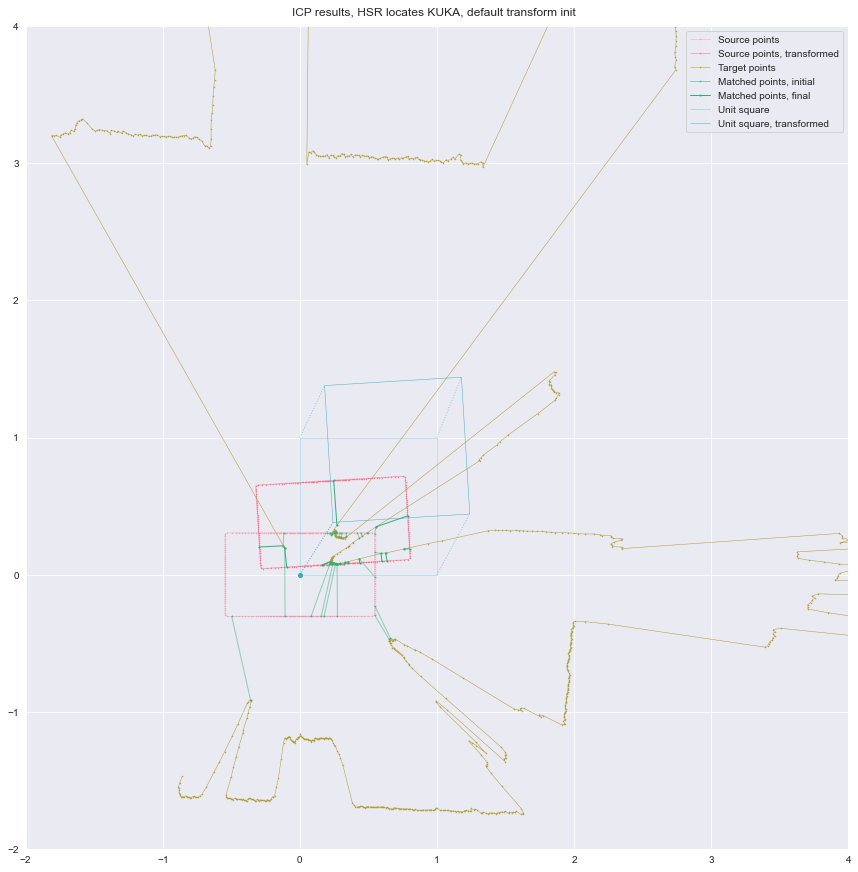

In [3]:
Icp(ptc_kuka, scan_hsr)(max_iter=100, min_d_err=1e-6)

# i.e. Identity transformation
visualize(
    ptc_kuka, scan_hsr,
    title='HSR locates KUKA, default transform init',
    xlim=[-2, 4], ylim=[-2, 4]
)



## An almost perfect guess
Only rotation is wrong, but the raw ICP output is not ideal



In [5]:
title = 'HSR locates KUKA, good transform init'
visualize(fp.ptc_b, scan_hsr, tsf=np.array([
    [1, 0, 3],
    [0, 1, -0.5],
    [0, 0, 1]
]), title=title, xlim=[-2, 5], ylim=[-2, 1])



ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[1., 0., 0.],
                     [0., 1., 0.],
                     [0., 0., 1.]])


TypeError: plot_icp_result() got multiple values for argument 'tsf'

## Cluster the point clouds first
then run ICP on each, with the relative translation to cluster center


### Clustering
What algorithm work well? Ideally the number of clusters shouldn't be fixed.


#### Setup



In [ ]:
c = Cluster.cluster

#### Spectral Clustering



In [ ]:
lbs = c(scan_hsr, approach='spectral', n_clusters=8)
plot_cluster(scan_hsr, lbs, title='Spectral on HSR')



#### Hierarchical Clustering



In [ ]:
def _(d):
    lbs = c(scan_hsr, approach='hierarchical', distance_threshold=d)
    plot_cluster(scan_hsr, lbs, title=f'Hierarchical on HSR, avg threshold={d}')

_(1)
_(2)



#### Gaussian Mixture Model assignment



In [ ]:
lbs = c(scan_hsr, approach='gaussian', n_components=6)
plot_cluster(scan_hsr, lbs, title='Gaussian on HSR, eps=0.5')



#### DBSCAN



In [ ]:
lbs = c(scan_hsr, approach='dbscan', eps=0.5, min_samples=16)
plot_cluster(scan_hsr, lbs, title='DBSCAN on HSR, eps=0.5')


### ICP with cluster translation initialisation


In [ ]:
lbs = c(scan_hsr, approach='hierarchical', distance_threshold=1)   # A good clustering result by empirical inspection
d_clusters = {lb: scan_hsr[np.where(lbs == lb)] for lb in np.unique(lbs)}

cls = d_clusters[1]  # The cluster indicating real location of KUKA

title = 'HSR locates KUKA, from the real cluster'
tsf = np.identity(3)
tsf[:2, -1] = cls.mean(axis=0)
ic(tsf)
visualize(ptc_kuka, scan_hsr, title=title, tsf=tsf)

